In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/netflix-data-aggregated.db')
netflix = pd.read_sql_query('select * from netflix', con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
netflix

,unit_id,dtime,address_v4,connect_time_v4,bytes_sec_v4,address_v6,connect_time_v6,bytes_sec_v6,delta_connect_time,delta_bytes_sec
0,123256,2016-07-22 00:00:00,198.38.119.140,20515,10371717,2a00:86c0:119:119::145,16803,10674265,3712,-302548
1,123256,2016-07-22 02:00:00,198.38.118.140,20570,10751181,2a00:86c0:119:119::142,17350,10958991,3220,-207810
2,123256,2016-07-22 04:00:00,198.38.119.149,15614,10388970,2a00:86c0:116:116::145,18747,9191069,-3133,1197901
3,123256,2016-07-22 10:00:00,198.38.119.149,18534,9844976,2a00:86c0:116:116::148,25121,8356098,-6587,1488878
4,123256,2016-07-22 13:00:00,198.38.117.153,23514,8260807,2a00:86c0:118:118::143,14076,10857188,9438,-2596381
...,...,...,...,...,...,...,...,...,...,...
969503,950234,2019-05-03 19:00:00,45.57.38.138,14564,116343808,2a00:86c0:2039:2039::142,11343,95874373,3221,20469435
969504,950234,2019-05-03 20:00:00,45.57.38.144,16070,112994705,2a00:86c0:2038:2038::141,9445,112935593,6625,59112
969505,950234,2019-05-03 21:00:00,45.57.38.136,8073,110344130,2a00:86c0:2038:2038::145,5363,98027453,2710,12316677
969506,950234,2019-05-03 22:00:00,45.57.39.143,14923,109319621,2a00:86c0:2038:2038::138,10461,110777402,4462,-1457781


In [5]:
netflix['delta_connect_time'] = netflix['delta_connect_time']/1000.0

In [6]:
netflix['dtime'] = netflix['dtime'].dt.floor('D')

In [7]:
netflix['year'] = netflix['dtime'].dt.year

In [8]:
df = netflix.groupby(['unit_id', 'dtime'], as_index=False
                    ).agg({'delta_connect_time' : 'median'}
                         )
df

,unit_id,dtime,delta_connect_time
0,62712,2017-01-31,-14.4155
1,62712,2017-02-01,-9.4255
2,62712,2017-02-02,-14.0110
3,62712,2017-02-03,-14.6070
4,62712,2017-02-04,-7.4100
...,...,...,...
48839,950240,2017-08-08,-0.1510
48840,950240,2017-08-09,-0.1380
48841,950240,2017-08-10,0.1210
48842,950240,2017-08-11,-0.0845


In [9]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [10]:
by_years = df.groupby('year')

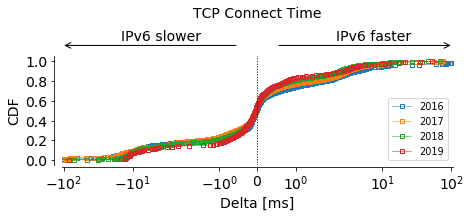

In [11]:
cdf_fig, cdf_ax = plt.subplots(figsize = (7, 2))

cdfs = []

for year, year_df in by_years:
    tcp_conn = Cdf.MakeCdfFromList(year_df['delta_connect_time'])

    cdf_ax.plot(tcp_conn.xs, tcp_conn.ps, label = year, marker = 's',
                linewidth = 0.5, markersize = 3.5, fillstyle = 'none',
                markevery=15)
    cdfs.append((year, 'TCP Connect Time Deltas', tcp_conn))

cdf_ax.set_ylim([-0.05, 1.05])
cdf_ax.set_xscale('symlog')
cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')

yticks = np.arange(0.0, 1.01, 0.2)
cdf_ax.set_yticks(yticks)
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.02))
cdf_ax.spines['left'].set_position(('axes', -0.02))

cdf_ax.set_title('TCP Connect Time', y=1.3)

cdf_ax.axvline(x=0.0, linewidth=1.0, color='black', ls = 'dotted')
    
cdf_ax.set_xlim([-105, 105])

cdf_ax.set_xlabel('Delta [ms]')
cdf_ax.set_ylabel('CDF')

cdf_ax.annotate('', xy = (0.45, 1.1), xycoords = 'axes fraction', xytext = (0, 1.1), 
            arrowprops = dict(arrowstyle = "<-"))
cdf_ax.annotate('', xy = (1, 1.1), xycoords = 'axes fraction', xytext = (0.55, 1.1), 
                    arrowprops = dict(arrowstyle="->"))

cdf_ax.text(0.15, 1.15, "IPv6 slower", transform=cdf_ax.transAxes)
cdf_ax.text(0.7, 1.15, "IPv6 faster", transform=cdf_ax.transAxes)

cdf_fig.subplots_adjust(hspace = 0.75)

cdf_fig.savefig('../plots/delta-tcp-conn-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [12]:
for year, version, cdf in cdfs:
    print(year, '\t\t', version)
    print('----------------')
    skip = int(len(cdf.xs)/150)
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f\t\t%.5f' % (x, p))
    print('\n===========================\n')

2016 		 TCP Connect Time Deltas
----------------
-4490.61		0.00012
-536.39		0.00489
-107.88		0.00966
-80.27		0.01443
-45.47		0.01920
-31.02		0.02397
-20.57		0.02874
-19.96		0.03352
-18.61		0.03840
-17.81		0.04317
-17.36		0.04795
-16.97		0.05283
-14.86		0.05761
-13.77		0.06261
-12.26		0.06738
-11.32		0.07215
-10.71		0.07692
-9.86		0.08181
-9.43		0.08658
-9.08		0.09147
-8.89		0.09647
-8.60		0.10136
-8.32		0.10648
-8.08		0.11137
-7.68		0.11614
-7.44		0.12115
-7.21		0.12638
-6.72		0.13115
-6.15		0.13639
-5.81		0.14116
-5.48		0.14628
-5.00		0.15129
-4.14		0.15606
-3.49		0.16083
-3.01		0.16595
-2.74		0.17095
-2.57		0.17572
-2.27		0.18084
-2.04		0.18585
-1.81		0.19074
-1.62		0.19574
-1.42		0.20086
-1.27		0.20598
-1.18		0.21110
-1.09		0.21680
-1.04		0.22216
-0.98		0.22751
-0.92		0.23379
-0.86		0.24031
-0.79		0.24636
-0.72		0.25265
-0.67		0.25777
-0.61		0.26405
-0.57		0.27022
-0.52		0.27557
-0.47		0.28244
-0.44		0.28837
-0.40		0.29408
-0.36		0.30106
-0.32		0.30769
-0.29		0.31514
-0.26		0.32270
